# Analyze A/B Test Results

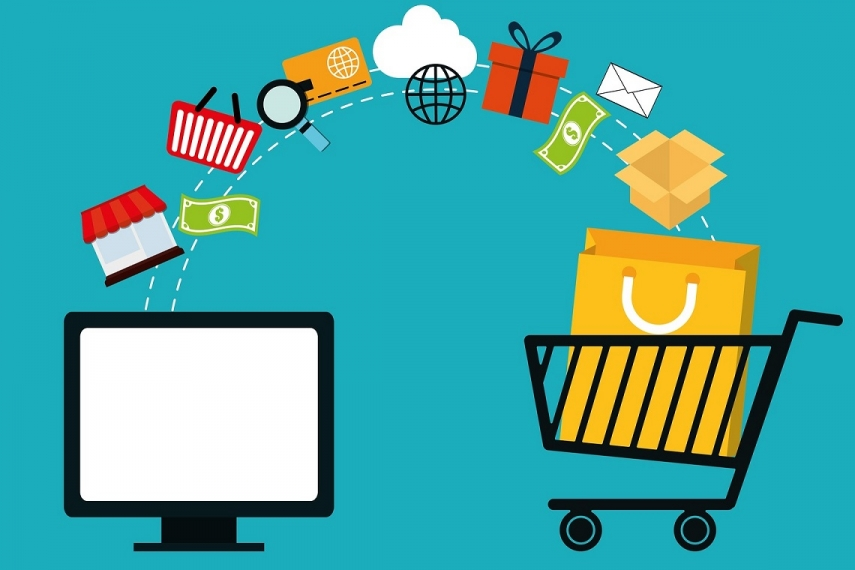     

 ## Table of Contents
1. [Introduction](#intro)
2. [Part I - Probability](#probability)
3. [Part II - A/B Test](#ab_test)
4. [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction
A/B tests are very commonly performed by data analysts and data scientists. It is important that we get some practice working with the difficulties of these tests.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
# importing the needed libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import timeit
%matplotlib inline

<a id='probability'></a>
## Part I - Probability

In [2]:
random.seed(42)

In [3]:
# reading the "ab_data" dataset
AB_data= pd.read_csv('ab_data.csv')

In [4]:
AB_data.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


**user_id**: the id associated with each user and it's unique; hence no two users share the same id.<br>
**timestamp**: is the date and time as when the user accessed the page. <br>
**group**: `1- treatment`, which are the people who got experemented on using the new page. `2- control`, which are the people who kept using the old page, and they're used as a baseline measure. <br>
**landing_page**: the `old` and the `new` page.<br>
**converted**: `0` for the users who did not pay for the company's product, and `1` for who did. 

In [5]:
#the number of rows
all_users=AB_data.shape[0]
all_users

294478

In [6]:
AB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [7]:
# the number of unique useres in the dataset
unique_users= AB_data['user_id'].nunique()
unique_users

290584

In [8]:
# getting the number of users converted
converted_users= (AB_data.query('converted==1')['user_id'].nunique())
converted_users

35173

In [9]:
# the proportion of users converted
prop_converted_users= converted_users/unique_users
prop_converted_users

0.12104245244060237

In [10]:
print("The proportion of the converted users equals approximately {0: .0%}".format(prop_converted_users))

The proportion of the converted users equals approximately  12%


In [11]:
# The number of times the new_page and treatment don't line up
NP_trmnt_NoLineUp=AB_data.query('(landing_page != "new_page" and group == "treatment") or (landing_page == "new_page" and group != "treatment")')['user_id'].count()
NP_trmnt_NoLineUp


3893

In [12]:
# missing values
if (AB_data.isnull().values.any()) == False:
    print("There's no missing value in ab_data dataset.")
elif (AB_data.isnull().values.any()) == True:
    null_num= AB_data.isnull().sum()
    if (null_num==1):
        print("There's {} missing value in ab_data dataset.".format(null_num))
    elif (null_num>1):
        print("There're {} missing values in ab_data dataset.".format(null_num))
    

There's no missing value in ab_data dataset.


In [13]:
AB_data_new= AB_data.copy()

I made a copy to keep my original data intact, in case anything went wrong during the analysis process 

In [14]:
AB_data_new.drop(AB_data_new.query('(landing_page != "new_page" and group == "treatment") or (landing_page == "new_page" and group != "treatment") or (landing_page != "old_page" and group == "control") or (landing_page == "old_page" and group != "control")').index, inplace=True)

I deleted the rows where treatment is not aligned with new_page or control is not aligned with old_page, because we cannot be sure if these rows truly received the new or old page. Hence it's useless to me. 

In [15]:
# making sure that the dropping process went well by subtracting the number of all users from our new updated dataset; the result should equal NP_trmnt_NoLineUp which I already calculated 
check= all_users - AB_data_new.shape[0]
check

3893

In [16]:
# making sure that the droped rows were the intended ones, the resault of the code should be 0
AB_data_new[((AB_data_new.landing_page == 'new_page')==(AB_data_new.group == 'treatment')) == False].shape[0]

0

The dropping process went very well. The rows that has mismatching were eliminated successfully. 

In [17]:
# the number of unique user_ids in AB_data_new
AB_data_new['user_id'].nunique()


290584

In [18]:
AB_data_new.shape[0]

290585

As it shows from the previous two cells that there's one repeated user id.

In [19]:
#the duplicated user_id with the row information
AB_data_new[AB_data_new.duplicated(subset=['user_id'], keep= False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [20]:
# getting rid of one of the duplicates
AB_data_new.drop(AB_data_new[(AB_data_new['user_id'] == 773192) & (AB_data_new['timestamp'] == '2017-01-09 05:37:58.781806')].index, inplace=True)

I got rid of one of the duplicates since the only difference between them is the timestame, and this difference does not affect my work. 

In [21]:
# checking the succsess of the dropping process 
AB_data_new[(AB_data_new['user_id'])==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


As we can see, there's only one user with the id **773192**.

In [22]:
# the number of converted users in AB_data_new
new_converted_users= AB_data_new.query('converted == 1')['user_id'].nunique()
new_converted_users

34753

In [23]:
#the probability of an individual converting regardless of the page they receive
new_prob_converted_users= new_converted_users/AB_data_new.shape[0]

In [24]:
print("The probability of an individual converting regardless of the page they receive equals {:.2%}".format(new_prob_converted_users))

The probability of an individual converting regardless of the page they receive equals 11.96%


In [25]:
#the users who converted while they're in the control group
control_converted_users= AB_data_new.query('group == "control" and converted == 1')['user_id'].nunique()
control_converted_users

17489

In [26]:
# all the users in the control group
control_users= AB_data_new.query('group == "control"')['user_id'].nunique()
control_users

145274

In [27]:
#the probability that users converted while they were in the control group
prob_control_converted_users= control_converted_users/control_users

In [28]:
print("The probability that users converted while they were in the control group equals {:.2%}".format(prob_control_converted_users))

The probability that users converted while they were in the control group equals 12.04%


In [29]:
#the users who converted while they're in the treatment group
treatment_converted_users= AB_data_new.query('group == "treatment" and converted == 1')['user_id'].nunique()
treatment_converted_users

17264

In [30]:
# all the users in the treatment group
treatment_users= AB_data_new.query('group == "treatment"')['user_id'].nunique()
treatment_users

145310

In [31]:
#the probability that users converted while they were in the treatment group
prob_treatment_converted_users= treatment_converted_users/treatment_users

In [32]:
print("The probability that users converted while they were in the treatment group equals {:.2%}".format(prob_treatment_converted_users))

The probability that users converted while they were in the treatment group equals 11.88%


In [33]:
# the numbers of users who received the new page
NewPage_users= AB_data_new.query('landing_page == "new_page"')['user_id'].nunique()
NewPage_users

145310

In [34]:
# the probability that an individual received the new page
prob_NewPage= NewPage_users/AB_data_new.shape[0]
prob_NewPage

0.5000619442226688

In [35]:
print("The probability that an individual received the new page equals {:.2%}".format(prob_NewPage))

The probability that an individual received the new page equals 50.01%


Notwithstanding the page that the users received, the probability of them converting is 11.96%. And if we took into consideration that the users were in the contol group (hence received the old page), the probability of them converting is 12.04%. Moreover, if we took into account that the users were in the treatment group (hence received the new page), the probability of them converting is 11.88%. <br>
If we look at this point at the numbers, we would probably say that the old page did a better job making the users convert, though it's a negligible convert. **Yet**, we can hardly consider these numbers a sufficient evidence; because the resaults are pretty close to each other and couldn't help us decide whether any page would lead to more conversions or not.

<a id='ab_test'></a>
## Part II - A/B Test

For now, let's consider for the sake of argument that I need to make the decision just based on all the data provided. If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null hypotheses would be **H0: $p_{new}$ - $p_{old}$<=0**, and the alternative hypotheses would be **H1: $p_{new}$ - $p_{old}$ >0.**

Let's assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, let's assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.<br>
we're going to perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null:

In [36]:
#the convert rate for 𝑝𝑛𝑒𝑤 under the null
p_new= AB_data_new.query('converted == 1')['user_id'].nunique()/AB_data_new.user_id.nunique()
p_new

0.11959708724499628

In [37]:
#the convert rate for 𝑝𝑜𝑙𝑑 under the null
p_old= AB_data_new.query('converted == 1')['user_id'].nunique()/AB_data_new.user_id.nunique()
p_old

0.11959708724499628

In [38]:
#the number of unique users who has new page using AB_data_new dataframe
n_new= AB_data_new.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

In [39]:
#the number of unique users who has old page using AB_data_new dataframe
n_old= AB_data_new.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

In [40]:
#Simulate n𝑛𝑒𝑤 transactions with a convert rate of p𝑛𝑒𝑤 under the null
new_page_converted= np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [41]:
#Simulate n𝑜𝑙𝑑 transactions with a convert rate of p𝑜𝑙𝑑 under the null
old_page_converted= np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
old_page_converted

array([1, 1, 0, ..., 1, 1, 1])

In [42]:
# 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 for the simulated values in the previous two cells
(new_page_converted.mean())-(old_page_converted.mean())

-0.0008170246352350308

In [43]:
#Simulate 10,000 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 values like what we just did 
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

(array([  23.,  181.,  744., 1931., 2881., 2482., 1272.,  404.,   76.,
           6.]),
 array([-0.00429   , -0.00339045, -0.0024909 , -0.00159135, -0.0006918 ,
         0.00020775,  0.0011073 ,  0.00200685,  0.0029064 ,  0.00380595,
         0.0047055 ]),
 <BarContainer object of 10 artists>)

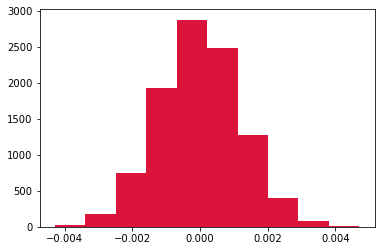

In [44]:
#Plotting a histogram of the p_diffs
plt.hist(p_diffs, color='crimson')

The proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv:

In [45]:
# distribution under the null hypothesis
null_v= np.random.normal(0, p_diffs.std(), p_diffs.size)

In [46]:
# number of users who converted in the new page and the old page
new_page_converted_users= AB_data_new.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
old_page_converted_users= AB_data_new.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()

In [47]:
# actual convert rate
new_actual_convert= new_page_converted_users/n_new
old_actual_convert= old_page_converted_users/n_old

In [48]:
#observed difference in converted rate 
converte_observed_difference= new_actual_convert - old_actual_convert
converte_observed_difference

-0.0015782389853555567

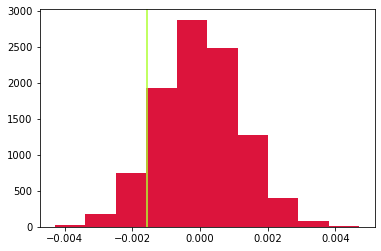

In [49]:
# the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv
plt.hist(p_diffs, color='crimson')
plt.axvline(x=converte_observed_difference,color ='greenyellow')

In [50]:
# the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv
p_value1=(null_v >converte_observed_difference).mean()
p_value1

0.9076

In scientific studies, there's a value calld the p-value. If we assumed that the null hypothesis was true and the p-value was less than 0.05, that would indicate there's a low probability in finding values remarkably greater-than, less-than or equal to `converte_observed_difference`. Since `p_old` (or `p_new`) does not fall within the critical region, we fail to reject the null hypothesis (p_old > Alpha --> 0.11959708724499628>0.05). Therefore, with a Type I error rate of 5% there's a higher probability of conversion in the old page than the new page. Also, the p_value is greater than Alpha, hence we accept the null hypothesis.<br>
P-values are the probability of obtaining an effect at least as extreme as the one in our sample data, assuming the truth of the null hypothesis.

source: https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-hypothesis-tests-significance-levels-alpha-and-p-values-in-statistics

In [51]:
# useing a built-in to achieve similar results to what we did above.
import statsmodels.api as sm

convert_old = old_page_converted_users
convert_new = new_page_converted_users
n_old=n_old
n_new=n_new

In [52]:
# using stats.proportions_ztest to compute my test statistic and p-value
Ztest_score, p_value2 = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [53]:
Ztest_score, p_value2

(-1.3109241984234394, 0.9050583127590245)

The minus sign before the `Ztest_score` value indicats that the value is below the mean.<br>
Since the `Ztest_score` (which is 1.3109241984234394) is not greater than 1.96 (which is the the critical value with significance of 5%), we fail to reject the null hypothesis; which means that the old page has a better converted rate than the new page or equal to it. Moreover, the `p-value` (which is 0.9050583127590245) is not less than 0.05, and it is nearly similar to the p-vale that we calculated previously (which is 0.9026). And these conculsions proves that the z-test is consistent with what we achieved so far.

Source: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjt7f_rkvPsAhWVQhUIHe4mCpYQFjABegQIBhAC&url=http%3A%2F%2Fcourses.washington.edu%2Furbdp520%2FUDP520%2FABHypTest.pdf&usg=AOvVaw1wbETcMrBlWGHcFeDhTm5O

<a id='regression'></a>
## Part III - A regression approach

Since each row is either a conversion or no conversion, Logistic Regression would be the ideal type of regression in this case. And also because we are intrested in knowing the odds of conversion, and Logistic Regression works with the categorical outcomes.

In [54]:
#creating a column for the intercept
AB_data_new['intercept'] = 1

we need an intercept term so that our regression output does not automatically predict probability 1/2 when our variables are all zero.<br><br>
source: https://www.quora.com/Why-do-we-add-a-column-of-1s-intercept-in-multiple-logistic-regression


In [55]:
#creating a dummy variable column for which page each user received
AB_data_new= AB_data_new.join(pd.get_dummies(AB_data_new['landing_page']))
AB_data_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [56]:
# adding an ab_page column, which is 1 when an individual receives the treatment and 0 if control
AB_data_new['ab_page'] = pd.get_dummies(AB_data['group']) ['treatment']
AB_data_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


I'm going to use statsmodels to import my regression model. Instantiate the model, and fit the model using the two columns I created above to predict whether or not an individual converts:

In [57]:
# Creating Logistic regression model for ab_page and the converted variable
Logistic_model1 = sm.Logit(AB_data_new['converted'], AB_data_new[['intercept','ab_page']])

In [58]:
Results1 = Logistic_model1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [59]:
print(Results1.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Nov 2020   Pseudo R-squ.:               8.077e-06
Time:                        21:51:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


As we can see, The p-value associated with ab_page is 0.190. This Logit Regression model is attempting to predict whether a user will convert based on whether their page is new or old. The null hypotheses is that there's no difference between the two groups (treatment and control). While the Alternative hypotheses is that there's difference.<br>
In Part II the assumption is that the old page is better except if the new page proves to be better at a `Type I` error rate of 5%. This part has different explanatory varibale or factor for the result in comparison to Part II.

<br>
Meanwhile, let's consider other things that might influence whether or not an individual converts; such as the time (timestamp variable). We can look and see if the converted rate is determined by a particular time or day when the users are using the website. And we can do so by turning the `timestamp` variable into a categorical variable, where it segments the time into `morning`, `afternoon`, `evening` and `past midnight`, or into `weekends` and `weekdays`. As helping and productive as this might seem, by adding additional terms into our regression model we're adding up to the complexity of interpretation. Also, the added terms might not affect the outcome, or it might affect the other participating variables; which might result in erroneous outcomes.

<br><br>Now along with testing if the conversion rate changes for different pages, we'll also add an effect based on which country a user lives. But first, we'll need to read in the countries.csv dataset and merge together our datasets on the approporiate rows:

In [60]:
# reading the "countries" dataset
countries= pd.read_csv('countries.csv')
countries.head(10)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK
5,909908,UK
6,811617,US
7,938122,US
8,887018,US
9,820683,US


In [61]:
# merging the two datasets on user_id
ABData_and_countries= AB_data_new.merge(countries, on ='user_id', how='left')
ABData_and_countries.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA


In [62]:
# getting the countries in country column to create the dummy variables
countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [63]:
# creating the dummy variables
ABData_and_countries[['CA','UK','US']] = pd.get_dummies(ABData_and_countries['country'])

In [64]:
ABData_and_countries.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA,1,0,0


In [65]:
Logistic_model2 = sm.Logit(ABData_and_countries['converted'], ABData_and_countries[['intercept','new_page', 'UK', 'US']])

In [66]:
Results2 = Logistic_model2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [67]:
print(Results2.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Nov 2020   Pseudo R-squ.:               2.323e-05
Time:                        21:51:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.0

Again, based on the p-value shown it does not appear that the country had an impact on the conversion.

<br><br><br>Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there's significant effects on conversion.

In [68]:
#Creating a new intereacton variable between new_page and country US, UK and CA
ABData_and_countries['UK_new_page'] = ABData_and_countries['new_page'] * ABData_and_countries['UK']
ABData_and_countries['US_new_page'] = ABData_and_countries['new_page'] * ABData_and_countries['US']
ABData_and_countries['CA_new_page'] = ABData_and_countries['new_page'] * ABData_and_countries['CA']

In [69]:
ABData_and_countries.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US,UK_new_page,US_new_page,CA_new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1,0,0,0


In [70]:
#Create logistic regression
Logistic_model3 = sm.Logit(ABData_and_countries['converted'], ABData_and_countries[['intercept','new_page', 'US_new_page', 'UK_new_page','UK','US']])

In [71]:
Results3 = Logistic_model3.fit()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [72]:
print(Results3.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Nov 2020   Pseudo R-squ.:               3.482e-05
Time:                        21:51:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US_new_page     0.0469      0.054      0.872    

In [73]:
np.exp(Results3.params)

intercept      0.134794
new_page       0.934776
US_new_page    1.048001
UK_new_page    1.081428
UK             1.011854
US             1.017682
dtype: float64

<br>The new_page's p-value is 0.195 which quite similar to the previous ones.<br>
As we can see from the `Logit Regression Results`, the new_page's coefficient differe from US_new_page's and UK_new_page's. Also, z-score for the variables weren't large enough for predicting conversion rate, and the p-values are grearter than 0.05 except for the intercept. For that reason, the location of the user who's using the page is irrelevant in terms of conversion rate.<br>
Moreover, the probability of conversion is 7.0% for every unit new_page decreases, holding all other varibles constant. Also, the likelihood of conversion for UK and new_page's users is 1.08 higher than CA and new_page's users, and 1.18% for the users in UK than CA, holding all other varibles constant. Additionally, the likelihood of conversion for US and new_page's users is 1.04 higher than CA and new_page's users, and 1.75% for the users in US than CA, holding all other varibles constant.<br><br>
In the end, we don't have enough evidence to reject the null hypothesis based on our A/B testing. So under these circumstances, there's no point in switching to the new page, when the old page is working just as well.